In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
import torch 
from torch import nn
import torch.nn.functional as F

import os
from pathlib import Path
from collections import Counter

In [2]:
def load_image_dataset(dataset_dir, shuffle= False):
    """Returns list of image paths and list of labels."""

    images_paths= []
    labels= []

    # iterate through each image folder
    for c in os.listdir(dataset_dir):
        c_dir = dataset_dir / c
        # if not a folder, continue
        if os.path.isfile(c_dir):
            continue
        # list all images inside image folder
        # append to list
        images= os.listdir(c_dir)
        for image in images:
            image_path= c_dir / image 
            images_paths.append(image_path)
            labels.append(c)

    # shuffle dataset
    if shuffle:
        import random
        random.seed(0)
        indices = list(zip(images_paths, labels))
        random.shuffle(indices)
        images_paths, labels = zip(*indices)

    return list(images_paths), list(labels)


# visualize images
def show_image(image_list, label_list):
    """Plot images."""
    
    fig = plt.figure(figsize=(10, 5))
    for i, file in enumerate(image_list):
        
        # if image is numpy array
        if isinstance(file, np.ndarray):
            img= file
        # if image is PIL image
        else:
            img = np.array(file)
        
        print('Image shape:', img.shape)
        ax = fig.add_subplot(2, int(len(image_list)/2), i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(label_list[i])
    plt.tight_layout()
    plt.show()

    
def image_to_array(image):
    """Convert PIL image to array."""
    image= Image.open(image)
    return np.asarray(image)


def array_to_image(array):
    """Convert array to PIL image"""
    image = Image.fromarray(array)
    image= image.convert('RGB')
    return image


def add_third_dim(images_list):
    """Add third dimension to image with 2 dimensions."""
    
    # get all images, convert to array
    images_array= [image_to_array(i) for i in images_list]

    # check dimensions before operation
    dims= []
    for image in images_array:
        dims.append(image.ndim)
    print(f'Before: {Counter(dims)}')

    # convert to 3d
    for i, image in enumerate(images_array):
        dim= image.ndim
        if dim == 3:
            continue
        images_array[i] = np.repeat(images_array[i][:, :, np.newaxis], 3, axis= 2)

    # check dimensions after operation
    dims= []
    for image in images_array:
        dims.append(image.ndim)
    print(f'After: {Counter(dims)}')
    
    # convert back array to image
    result_images= [array_to_image(i) for i in images_array]
    
    return result_images

# Load Dataset

In [3]:
dir_= Path('/kaggle/input/covid19-image-dataset/Covid19-dataset/train')
X_train_val, y_train_val= load_image_dataset(dir_, shuffle= True)

dir_= Path('/kaggle/input/covid19-image-dataset/Covid19-dataset/test')
X_test, y_test= load_image_dataset(dir_, shuffle= True)

In [4]:
# deal with missing dimensions
# some images only have 2 dims
# we will make it in 3 dims

print('Train val set:')
X_train_val= add_third_dim(X_train_val)

print('\nTest set:')
X_test= add_third_dim(X_test)

Train val set:
Before: Counter({3: 214, 2: 37})
After: Counter({3: 251})

Test set:
Before: Counter({3: 61, 2: 5})
After: Counter({3: 66})


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size= 0.2, random_state= 1)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

200 200
51 51
66 66


Image shape: (2953, 3604, 3)
Image shape: (1231, 1109, 3)
Image shape: (2057, 2498, 3)
Image shape: (990, 1458, 3)
Image shape: (631, 790, 3)
Image shape: (1827, 2271, 3)
Image shape: (816, 999, 3)
Image shape: (2458, 2720, 3)
Image shape: (1080, 1456, 3)
Image shape: (1800, 1750, 3)


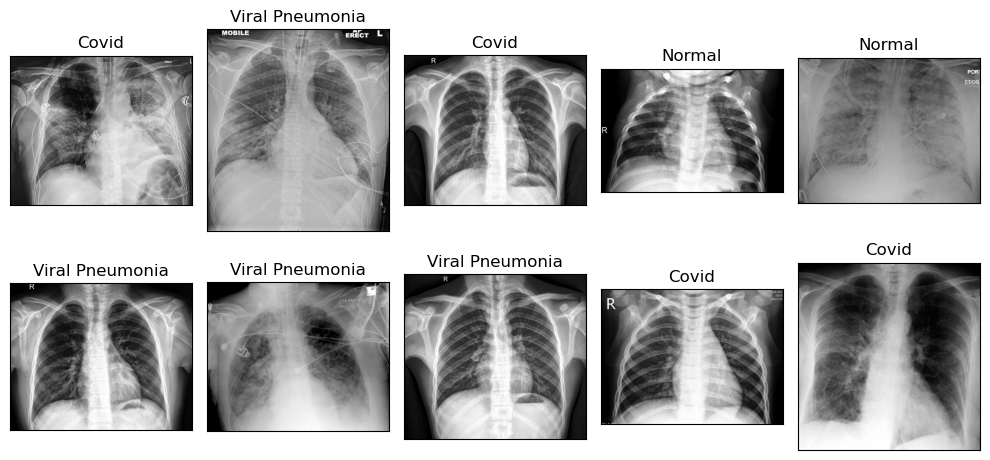

In [6]:
show_image(X_train[-10:], y_train)

# Preprocessing

In [7]:
# encode label
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
labels= np.array(y_train + y_val + y_test)
encoder.fit(labels)

y_train= encoder.transform(np.array(y_train))
y_val= encoder.transform(np.array(y_val))
y_test= encoder.transform(np.array(y_test))

In [8]:
# create transformation pipeline
# to resize data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

img_height, img_width = 128, 128
transform = transforms.Compose(
    [
        # transform PIL image to tensor
        transforms.ToTensor(),
        # resize images
        transforms.Resize((img_height, img_width), antialias=True),
    ]
)

# create dataset class
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img = self.file_list[index]
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

# Create Dataset

In [9]:
# create dataset
batch_size = 4

train_set = ImageDataset(X_train, y_train, transform)
val_set = ImageDataset(X_val, y_val, transform)
test_set = ImageDataset(X_test, y_test, transform)

train_dl = DataLoader(train_set, batch_size=batch_size)
val_dl = DataLoader(val_set, batch_size=batch_size)
test_dl = DataLoader(test_set, batch_size=batch_size)

# Create Model

In [10]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, 
                               out_channels= 6, 
                               kernel_size= 5, 
                               padding= 2)
        self.pool = nn.MaxPool2d(kernel_size= 2, 
                                 stride= 2,)
        self.conv2 = nn.Conv2d(in_channels= 6, 
                               out_channels= 16, 
                               kernel_size= 5)
        self.fc1 = nn.Linear(14400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        self.softmax = nn.Softmax(dim= 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv 1
        x = self.pool(F.relu(self.conv2(x))) # conv 2
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # fully connected 1
        x = F.relu(self.fc2(x)) # fully connected 2
        x = self.fc3(x) # fully connected 3 without relu
        x = self.softmax(x)
        return x
    
my_cnn_model= MyCNN()

# Training and Validation

In [11]:
def train(model, n_epochs, train_dl, val_dl):
    n_train_samples = len(train_dl.dataset)
    n_val_samples = len(val_dl.dataset)

    loss_hist_train = [0] * n_epochs
    acc_hist_train = [0] * n_epochs
    loss_hist_val = [0] * n_epochs
    acc_hist_val = [0] * n_epochs

    # training
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_dl:
            y_pred_proba = model(X_batch)
            y_pred = torch.argmax(y_pred_proba, dim=1)
            loss = loss_fn(y_pred_proba, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            is_correct = (y_batch == y_pred).float()
            acc_hist_train[epoch] += is_correct.sum()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
        loss_hist_train[epoch] /= n_train_samples
        acc_hist_train[epoch] /= n_train_samples

        # validation
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_dl:
                y_pred_proba = model(X_batch)
                y_pred = torch.argmax(y_pred_proba, dim=1)
                loss = loss_fn(y_pred_proba, y_batch)
                is_correct = (y_batch == y_pred).float()
                acc_hist_val[epoch] += is_correct.sum()
                loss_hist_val[epoch] += loss.item() * y_batch.size(0)
            loss_hist_val[epoch] /= n_val_samples
            acc_hist_val[epoch] /= n_val_samples

        train_acc = acc_hist_train[epoch]
        val_acc = acc_hist_val[epoch]
        if (epoch + 1) % 1 == 0:
            print(
                f"Epoch {epoch + 1}\n"
                f"Train accuracy = {train_acc: .3f}, "
                f"val accuracy = {val_acc: .3f}"
            )

    return (loss_hist_train, acc_hist_train, loss_hist_val, acc_hist_val)

In [12]:
# training
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(my_cnn_model.parameters(), lr=0.0001)

n_epochs = 10
hist = train(my_cnn_model, n_epochs, train_dl, val_dl)
loss_hist_train, acc_hist_train, loss_hist_val, acc_hist_val = hist

Epoch 1
Train accuracy =  0.460, val accuracy =  0.490
Epoch 2
Train accuracy =  0.590, val accuracy =  0.725
Epoch 3
Train accuracy =  0.770, val accuracy =  0.824
Epoch 4
Train accuracy =  0.890, val accuracy =  0.804
Epoch 5
Train accuracy =  0.885, val accuracy =  0.824
Epoch 6
Train accuracy =  0.885, val accuracy =  0.863
Epoch 7
Train accuracy =  0.910, val accuracy =  0.863
Epoch 8
Train accuracy =  0.930, val accuracy =  0.863
Epoch 9
Train accuracy =  0.935, val accuracy =  0.863
Epoch 10
Train accuracy =  0.935, val accuracy =  0.882


# Test

In [13]:
test_acc= 0
n_test_samples= len(test_dl.dataset)

X= []
y_preds= []
y_trues= []

my_cnn_model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        y_pred_proba= my_cnn_model(x_batch)
        y_pred= torch.argmax(y_pred_proba, dim= 1)
        is_correct= (y_pred == y_batch).float()
        test_acc += is_correct.sum()
        X.append(x_batch)
        y_preds.append(y_pred)
        y_trues.append(y_batch)

test_acc /= n_test_samples
print(f'Test accuracy = {test_acc: .3f}')

Test accuracy =  0.818


In [14]:
# get images to visualzie
images= torch.cat([X[i] for i in range(0, 4)])
true_labels= torch.cat([y_trues[i] for i in range(0, 4)])
pred_labels= torch.cat([y_preds[i] for i in range(0, 4)])

# inverse encode to get string label
true_labels= encoder.inverse_transform(true_labels)
pred_labels= encoder.inverse_transform(pred_labels)

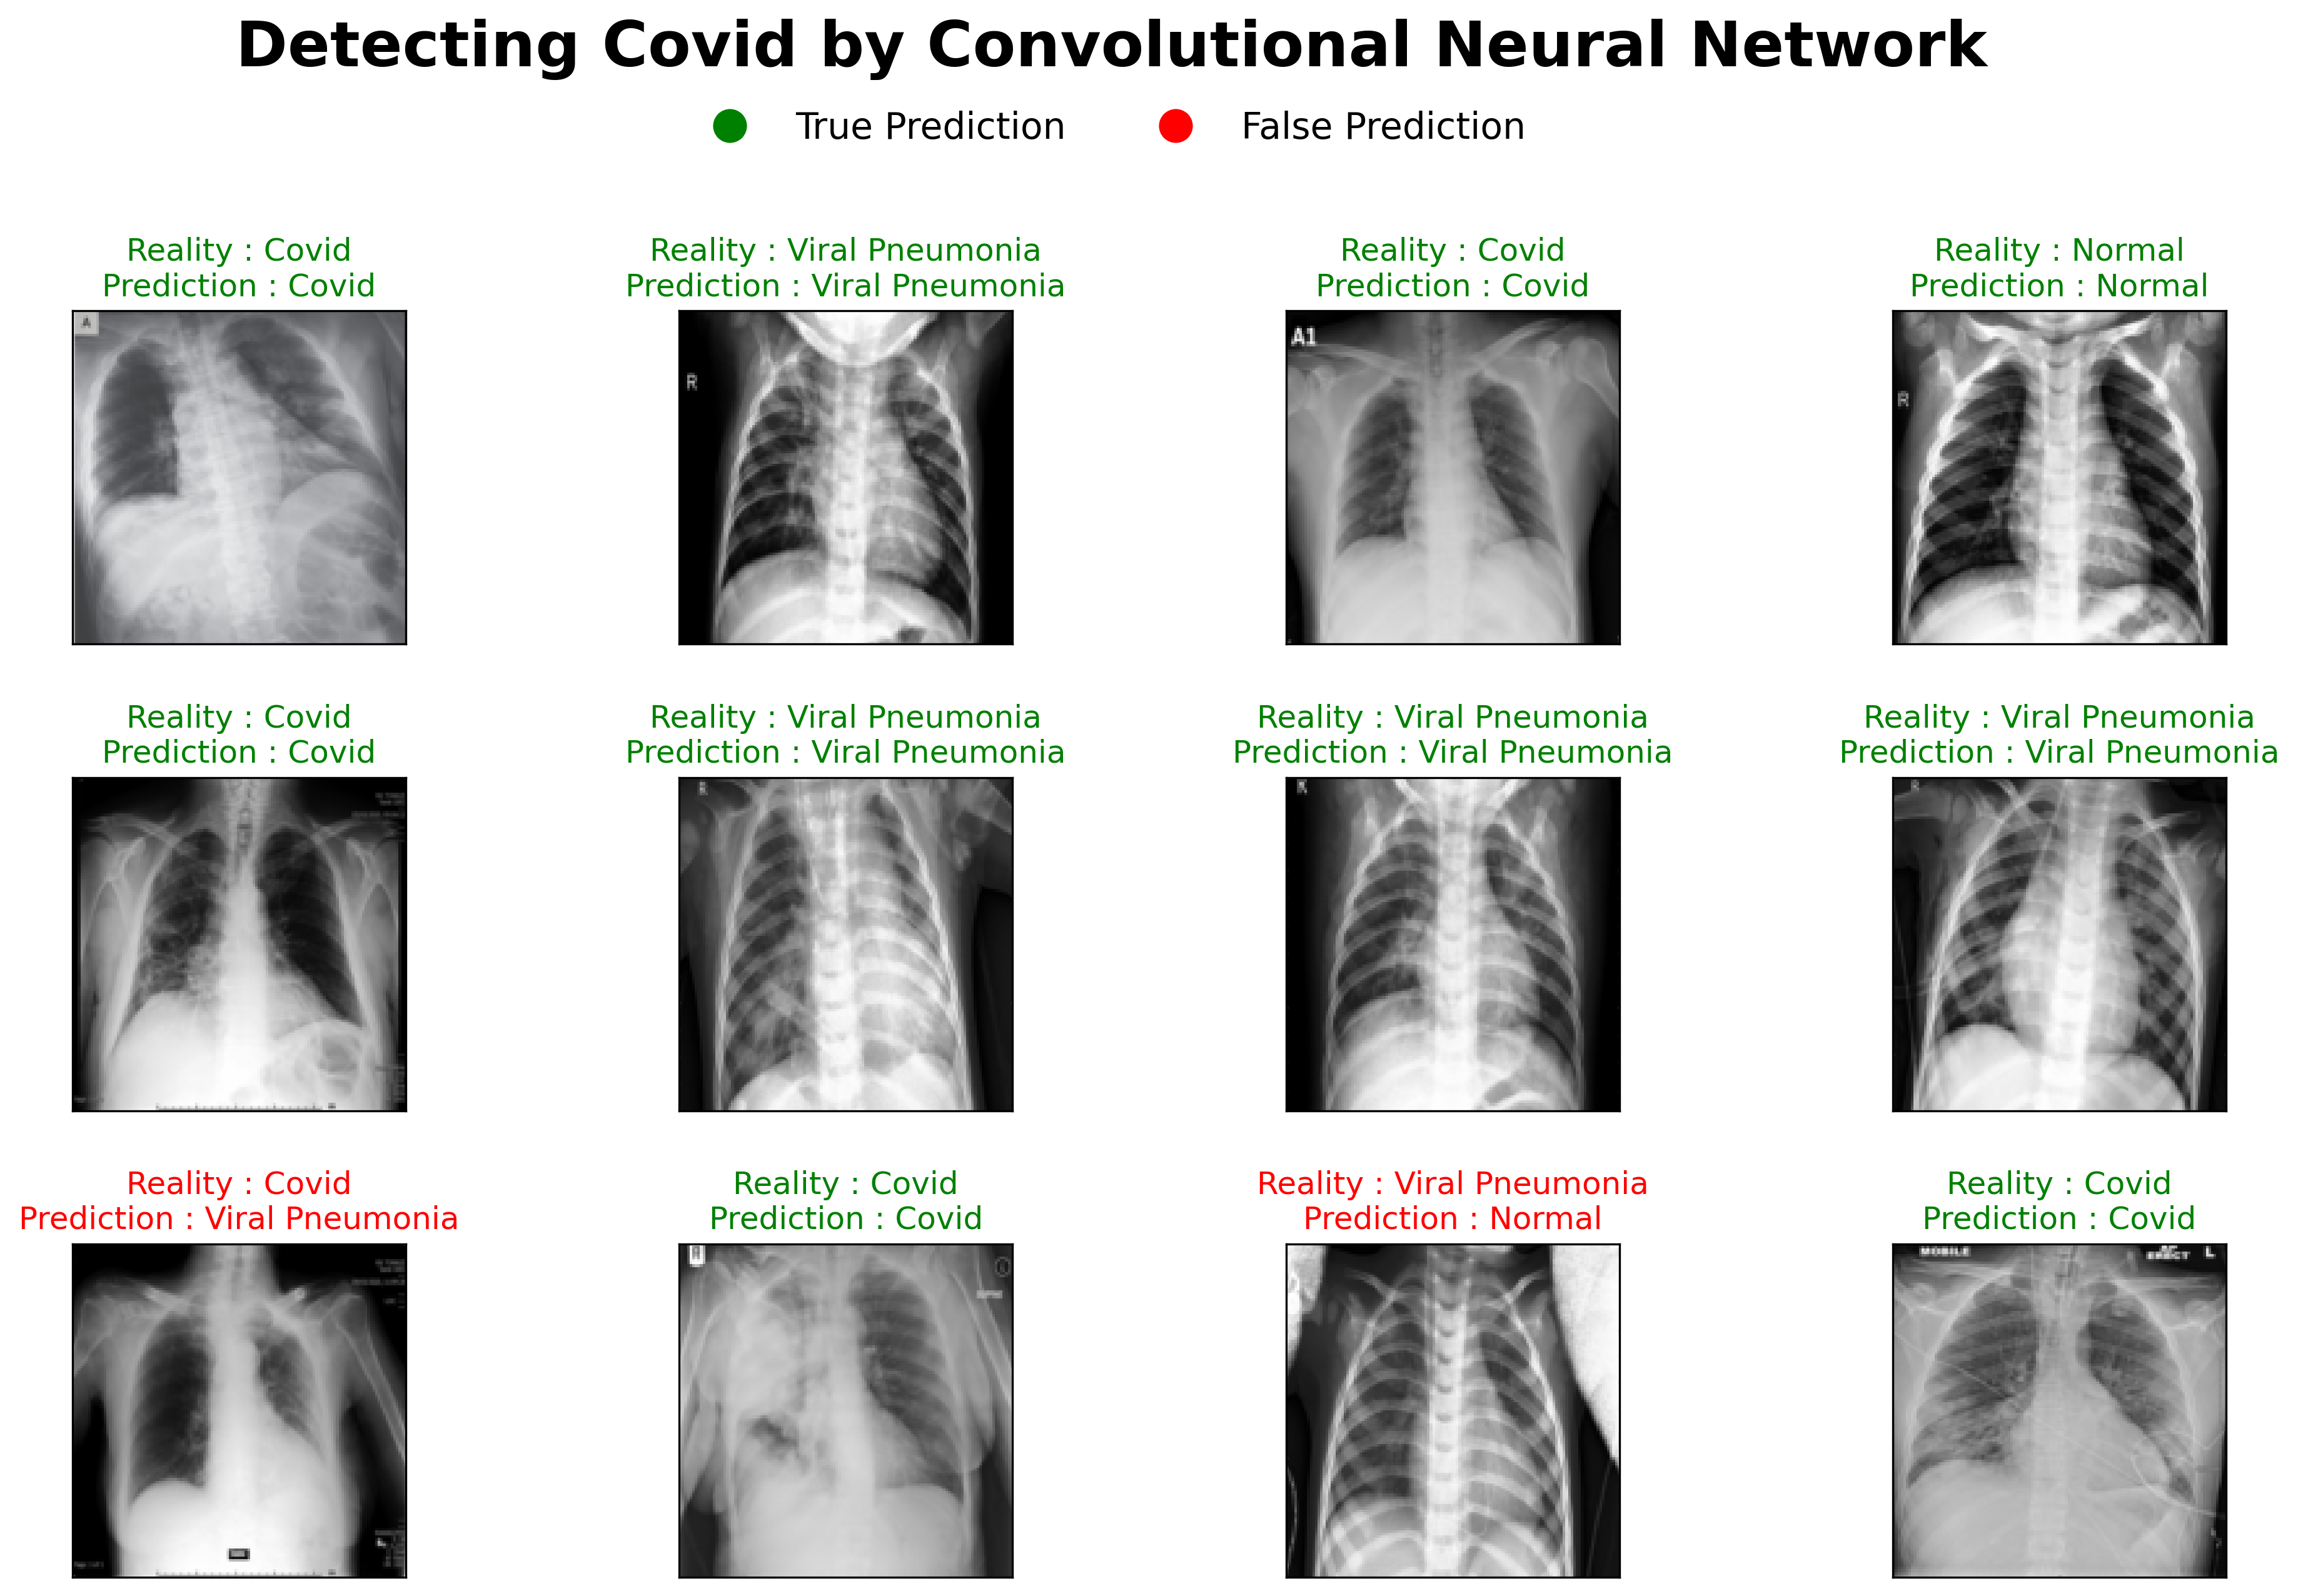

In [15]:
fig = plt.figure(figsize= (16, 12), dpi= 300)
plt.subplots_adjust(wspace= 0.2, hspace= 0.4)

for j in range(0, len(images)-4):
    
    # add figure
    ax = fig.add_subplot(4, 4, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    
    # plot image
    ax.imshow(images[j].permute(1, 2, 0))
    
    # plot y_pred and y_true
    title= f'Reality : {true_labels[j]}\nPrediction : {pred_labels[j]}'
    if true_labels[j] == pred_labels[j]:
        color= 'green'
    else:
        color= 'red'
    ax.set_title(title, color= color)

fig.suptitle("Detecting Covid by Convolutional Neural Network", fontsize= 24, fontweight='bold', y= 1.01)

# create custom legend
custom_legend = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=14),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=14)
]
legend_labels = ['True Prediction', 'False Prediction']
ax.legend(custom_legend, legend_labels, loc= 'upper center', bbox_to_anchor=(-2.35, 4.5), ncols= 2, frameon= False, fontsize= 14)

plt.savefig('result.png', bbox_inches= 'tight')
plt.show()